In [1]:
!conda activate DS807

## Preparation of data

### Labeling Data and converting images to array values

In [16]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray

In [17]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [18]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [19]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,2725,1806,0,0,6,"[[[132.0], [136.0], [135.0], [135.0], [135.0],...",2725.jpg
1,7488,1806,0,0,6,"[[[165.0], [163.0], [164.0], [166.0], [163.0],...",7488.jpg
2,6082,1821,0,2,1,"[[[158.0], [149.0], [157.0], [160.0], [156.0],...",6082.jpg
3,1481,1815,0,1,5,"[[[147.0], [147.0], [148.0], [151.0], [148.0],...",1481.jpg
4,9926,1807,0,0,7,"[[[134.0], [136.0], [128.0], [134.0], [142.0],...",9926.jpg
...,...,...,...,...,...,...,...
11995,4340,1826,0,2,6,"[[[26.0], [22.0], [11.0], [26.0], [32.0], [22....",4340.jpg
11996,6307,1838,0,3,8,"[[[168.0], [165.0], [169.0], [174.0], [175.0],...",6307.jpg
11997,3308,1828,0,2,8,"[[[35.0], [54.0], [149.0], [134.0], [141.0], [...",3308.jpg
11998,5415,1814,0,1,4,"[[[169.0], [170.0], [172.0], [171.0], [169.0],...",5415.jpg


### Defining fixed train, test and valdiation sets.

In [20]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [21]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [22]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [23]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.2.C, Data augmentation in modelling

In [24]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

In [66]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 1))])

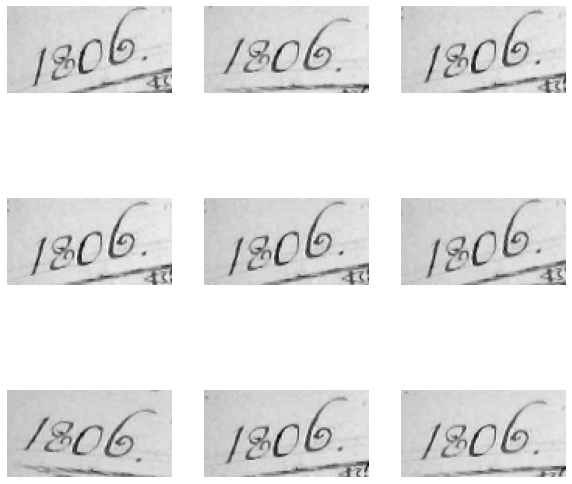

In [67]:
sample_image = x_train[1:2].copy()
plt.figure(figsize=(10, 10))
for i in range(9):
    augim = data_augmentation(sample_image, training=True)[0] # Stress training=True
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(augim, cmap = 'gray')

In [69]:
augim.shape

TensorShape([56, 106, 1])

In [12]:
model_da = tf.keras.models.Sequential([
    data_augmentation, # only new part!
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
    ])
model_da.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )

In [72]:
augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) 
test_datagen = ImageDataGenerator(rescale=1./255) 

###

history = cnn_model.fit(train_datagen, 
                        steps_per_epoch=len(train_data)//32, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=validation_generator, 
                        validation_steps = 416/32)
